In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time

from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2
import pandas as pd

from enviroments import TimeSeriesEnv



In [7]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 1000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 200  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 10  # Terminal states (end of episodes)
MODEL_NAME = 'window48_profit'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 1000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 100  # episodes
SHOW_PREVIEW = True

# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')




In [10]:

df = pd.read_csv('SP500.csv')
data = df['Close'].values
data

array([1132.98999 , 1136.52002 , 1137.140015, ..., 3240.02002 ,
       3221.290039, 3230.780029])

In [11]:
len(data)  * 0.8

2012.8000000000002

In [12]:
from enviroments import TimeSeriesEnv
#add_trend = np.logspace(np.log(1.08), np.log(2), 500, base=np.exp(2))
#data = np.sin(np.linspace(0, 100, 500)).astype(np.float32)# + add_trend
data_split = int(len(data)  * 0.8)
train_data = data[:data_split]
valid_data = data[data_split:]

env = TimeSeriesEnv(train_data, window_size=48)
valid_env = TimeSeriesEnv(valid_data,window_size=48)

In [42]:
import gym

envs = gym.vector.AsyncVectorEnv([lambda: TimeSeriesEnv(train_data, window_size=48)] * 3)

In [43]:

env._get_observation()

array([0.0662097 , 0.06832656, 0.06869835, 0.07142682, 0.07339976,
       0.0745991 , 0.06814663, 0.07381957, 0.07548661, 0.06803273,
       0.07654803, 0.06923807, 0.05630912, 0.04148526, 0.04449563,
       0.04173115, 0.04492737, 0.03714965, 0.03075713, 0.03994407,
       0.04841743, 0.04479546, 0.02430466, 0.02615163, 0.02048476,
       0.02874825, 0.02731503, 0.03351561, 0.0317406 , 0.04335023,
       0.04613272, 0.05047433, 0.05192557, 0.05122992, 0.04318831,
       0.04956882, 0.04818955, 0.04911907, 0.05584737, 0.05740657,
       0.0576944 , 0.06020099, 0.0696338 , 0.0695139 , 0.07068323,
       0.07377756, 0.07655404, 0.07640412], dtype=float32)

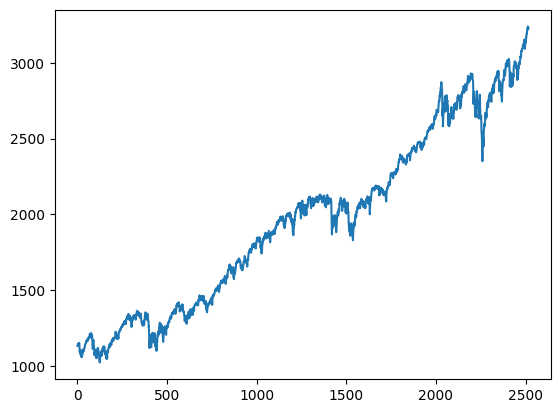

In [44]:
import matplotlib.pyplot as plt

plt.plot(data)

In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prosta sieć neuronowa w PyTorchu
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.output(x)

class DQNAgent:
    def __init__(self):
        self.model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, terminal_state, step, min_val, max_val):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Rozpakowanie danych
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states_v = torch.from_numpy(np.array(states)).float().to(device)
        next_states_v = torch.from_numpy(np.array(next_states)).float().to(device)
        actions_v = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards_v = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones_v = torch.tensor(dones, dtype=torch.bool, device=device)        
        
        with torch.no_grad():
            target_qs = self.target_model(next_states_v)
            max_future_qs = torch.max(target_qs, dim=1)[0]
            new_qs = rewards_v + (~dones_v * DISCOUNT * max_future_qs)

        current_qs = self.model(states_v)
        predicted_qs = current_qs.gather(1, actions_v.unsqueeze(1)).squeeze()

        loss = self.loss_fn(predicted_qs, new_qs)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if terminal_state:
            self.target_update_counter += 1

        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.load_state_dict(self.model.state_dict())
            self.target_update_counter = 0

    def get_qs(self, state):
        #state = np.array(state) / 255.0
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            qs = self.model(state_v)
        return qs.cpu().numpy()[0]


In [14]:
agent = DQNAgent()

In [47]:
import multiprocessing


def train_episode(agent,episode, epsilon):

    episode_reward = 0
    step = 1

    current_state = env.reset()

    done = False
    while not done:

        if np.random.random() > epsilon:
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward


        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step, env.min_val, env.max_val)

        current_state = new_state
        step += 1
 
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            print(f"Episode: {episode} Total Reward: {env.total_profit} Epsilon: {epsilon:.2f}")

    
    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

    return episode_reward

EPISODES = 400
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    train_episode(agent,episode,epsilon)

#przed opt - 18 min

 25%|##5       | 100/400 [11:17<39:13,  7.84s/episodes]

Episode: 100 Total Reward: 18553.920019000005 Epsilon: 1.00


 50%|#####     | 200/400 [24:04<23:52,  7.16s/episodes]

Episode: 200 Total Reward: 27399.058780000014 Epsilon: 1.00


 75%|#######5  | 300/400 [35:14<11:25,  6.85s/episodes]

Episode: 300 Total Reward: 23104.159533000002 Epsilon: 1.00


100%|##########| 400/400 [46:48<00:00,  7.02s/episodes]

Episode: 400 Total Reward: 49744.729121999946 Epsilon: 1.00


In [48]:
# from multiprocessing import Pool
# from tqdm import tqdm

# def train_wrapper(episode, epsilon):
#     return train_episode(episode, epsilon)

# if __name__ == "__main__":
#     with Pool() as pool:
#         results = list(tqdm(pool.starmap(train_wrapper, [(episode, epsilon) for episode in range(1, EPISODES + 1)]), total=EPISODES, ascii=True, unit='episodes'))

In [49]:
#from multiprocessing import Pool




#with Pool() as p:
#    print(p.map(train_episode, [episode for episode in range(1, EPISODES + 1)]))

In [ ]:
def save_dqn_agent(agent, filename="dqn_model.pth"):
    torch.save({
        'model_state_dict': agent.model.state_dict(),
        'target_model_state_dict': agent.target_model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
    }, filename)

#save_dqn_agent(agent, "trained_agent_stock.pth")

In [15]:
def load_dqn_agent(agent, filename="dqn_model.pth"):
    checkpoint = torch.load(filename, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.target_model.load_state_dict(checkpoint['target_model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model załadowany z {filename}")
    
load_dqn_agent(agent, "trained_agent_stock.pth")

Model załadowany z trained_agent_stock.pth


C:\Users\proso\AppData\Local\Temp\ipykernel_26812\919574584.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device("

In [17]:
from source.IB_connector import retrive_market_data

training_set_aapl = retrive_market_data(["AAPL"], duration = "7 d", time_interval = "30 mins")
training_set = training_set_aapl['AAPL']

training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")

training_set

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


,Date,Open,High,Low,Close,Volume
0,2025-05-12 09:30:00,210.93,211.26,206.75,208.53,9903698
1,2025-05-12 10:00:00,208.53,210.09,208.46,209.16,5415617
2,2025-05-12 10:30:00,209.17,210.23,208.48,209.12,2849161
3,2025-05-12 11:00:00,209.12,209.13,208.11,208.76,1987464
4,2025-05-12 11:30:00,208.77,208.99,208.40,208.43,1565483
...,...,...,...,...,...,...
82,2025-05-20 11:30:00,207.65,208.43,207.00,207.92,2047229
83,2025-05-20 12:00:00,207.91,208.08,207.40,207.81,1124577
84,2025-05-20 12:30:00,207.81,208.02,207.58,207.61,888716
85,2025-05-20 13:00:00,207.61,207.74,207.11,207.38,1248274


In [18]:
training_set

,Date,Open,High,Low,Close,Volume
0,2025-05-12 09:30:00,210.93,211.26,206.75,208.53,9903698
1,2025-05-12 10:00:00,208.53,210.09,208.46,209.16,5415617
2,2025-05-12 10:30:00,209.17,210.23,208.48,209.12,2849161
3,2025-05-12 11:00:00,209.12,209.13,208.11,208.76,1987464
4,2025-05-12 11:30:00,208.77,208.99,208.40,208.43,1565483
...,...,...,...,...,...,...
82,2025-05-20 11:30:00,207.65,208.43,207.00,207.92,2047229
83,2025-05-20 12:00:00,207.91,208.08,207.40,207.81,1124577
84,2025-05-20 12:30:00,207.81,208.02,207.58,207.61,888716
85,2025-05-20 13:00:00,207.61,207.74,207.11,207.38,1248274


In [19]:
training_set['Close'].values[int(training_set.shape[0]* .9):]

array([207.51, 207.84, 207.59, 207.63, 207.92, 207.81, 207.61, 207.38,
       207.16])

In [21]:
aapl_env = TimeSeriesEnv(training_set['Close'].values, 48)

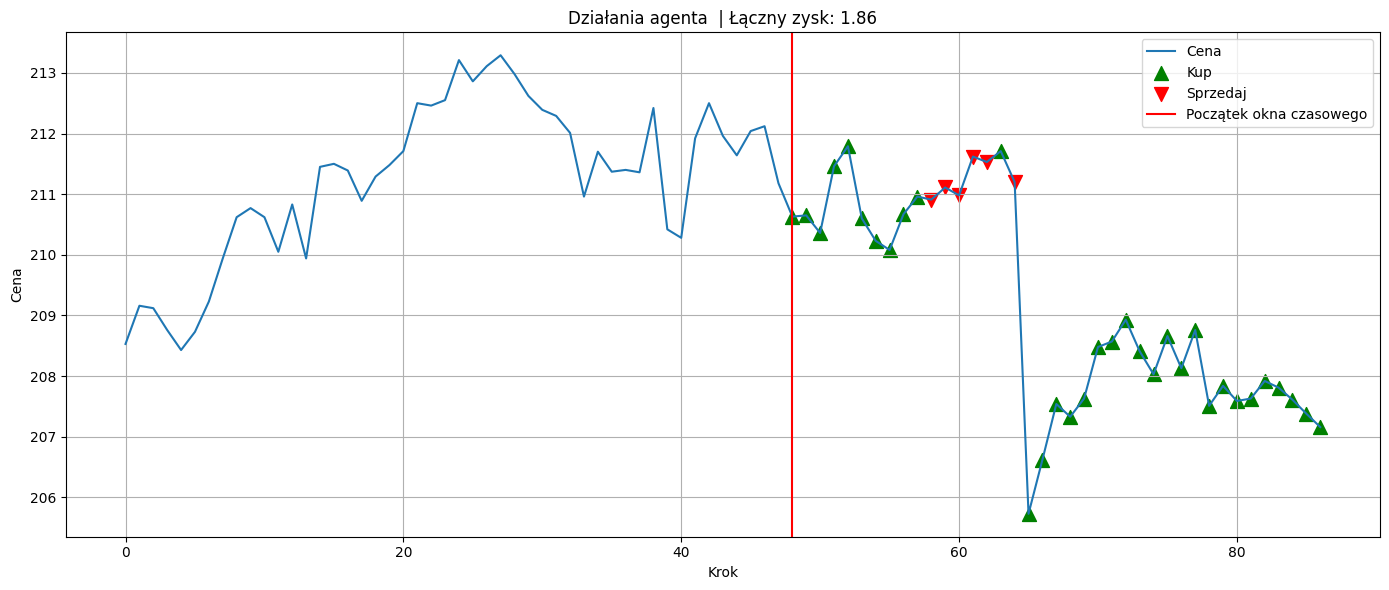

In [22]:
import torch
import matplotlib.pyplot as plt


def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward


def render_env(env, title_suffix=""):
    prices = env.data
    buy_points = env.states_buy
    sell_points = env.states_sell
    profit = env.total_profit

    plt.figure(figsize=(14, 6))
    plt.plot(prices, label='Cena', linewidth=1.5)

    if buy_points:
        plt.scatter(buy_points, [prices[i] for i in buy_points],
                    color='green', marker='^', label='Kup', s=100)
    if sell_points:
        plt.scatter(sell_points, [prices[i] for i in sell_points],
                    color='red', marker='v', label='Sprzedaj', s=100)

    plt.title(f'Działania agenta {title_suffix} | Łączny zysk: {profit:.2f}')
    plt.axvline(x = 48, color = 'red', label = 'Początek okna czasowego')
    plt.xlabel('Krok')
    plt.ylabel('Cena')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


aapl_env.reset()
evaluate_steps(aapl_env, agent.target_model)
render_env(aapl_env, title_suffix="")

In [25]:
len(aapl_env.states_buy)

33

In [26]:
len(aapl_env.inventory)

27

In [29]:
sum(aapl_env.inventory -aapl_env.data[-1])

31.60000000000005